In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import root_scalar
from scipy.stats import norm

# -------------------------------
# 1. 读取数据
# -------------------------------
df = pd.read_excel('male.xlsx')

# 确认列名一致
# df.columns

# -------------------------------
# 2. 计算Y染色体达标时间
# 模型: Yij = f(GAij, BMIi, β) + bi + ϵij
# 我们用线性近似 f(GA,BMI)=a*GA+b*BMI+c
# -------------------------------
# 线性近似拟合 Y ~ GA + BMI
from sklearn.linear_model import LinearRegression

X = df[['检测孕周', '孕妇BMI']]
y = df['Y染色体浓度']

model = LinearRegression()
model.fit(X, y)

a, b = model.coef_
c = model.intercept_

# 定义个体达标函数
def calc_GAmin(Y_target, BMIi):
    # Y = a*GA + b*BMI + c => GA = (Y - b*BMI - c)/a
    return (Y_target - b*BMIi - c)/a

df['GA_min'] = df['孕妇BMI'].apply(lambda bmi: calc_GAmin(0.04, bmi))
# 对未达标设定右截断 25 周
df['GA_min'] = df['GA_min'].apply(lambda x: x if x <= 25 else 25)

# -------------------------------
# 3. BMI分组动态规划优化
# -------------------------------
def dp_bmi_group(df, k):
    # 排序BMI
    df_sorted = df.sort_values('孕妇BMI').reset_index(drop=True)
    BMI = df_sorted['孕妇BMI'].values
    GAmin = df_sorted['GA_min'].values
    n = len(BMI)
    
    # 预计算区间方差
    var_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            var_matrix[i,j] = np.var(GAmin[i:j+1])
    
    # DP初始化
    dp = np.full((k, n), np.inf)
    track = np.zeros((k, n), dtype=int)
    
    for i in range(n):
        dp[0,i] = var_matrix[0,i]
    
    for group in range(1, k):
        for i in range(group, n):
            for j in range(group-1, i):
                cost = dp[group-1,j] + var_matrix[j+1,i]
                if cost < dp[group,i]:
                    dp[group,i] = cost
                    track[group,i] = j
    
    # 回溯分组界点
    borders = []
    idx = n-1
    for group in reversed(range(1, k)):
        j = track[group, idx]
        borders.append(BMI[j])
        idx = j
    borders = sorted(borders)
    return borders

# 假设 k=5
k = 5
bmi_cutoffs = dp_bmi_group(df, k)
print("BMI分组界点:", bmi_cutoffs)

# -------------------------------
# 4. 计算每组最佳检测时点
# -------------------------------
df['BMI_group'] = pd.cut(df['孕妇BMI'], bins=[0]+bmi_cutoffs+[np.inf], right=False)

def best_GA_for_group(group_df, Y_target=0.04, coverage=0.95):
    # 模拟随机效应 bi ~ N(0, σb^2)
    # 简化假设 σb = 0.01
    sigma_b = 0.01
    n_sim = 1000
    GA_samples = []
    for _, row in group_df.iterrows():
        bmi = row['孕妇BMI']
        sims = calc_GAmin(Y_target, bmi) + np.random.normal(0, sigma_b, n_sim)
        # 取使得达标概率 >= coverage 的最小GA
        GA = np.percentile(sims, (1-coverage)*100)
        GA_samples.append(GA)
    return np.mean(GA_samples), np.percentile(GA_samples, 2.5), np.percentile(GA_samples, 97.5)

result_list = []
for name, group in df.groupby('BMI_group'):
    GA_mean, GA_low, GA_high = best_GA_for_group(group)
    result_list.append({
        'BMI_group': str(name),
        'sample_size': len(group),
        'best_GA': GA_mean,
        'CI_low': GA_low,
        'CI_high': GA_high
    })

result_df = pd.DataFrame(result_list)
print(result_df)

# -------------------------------
# 5. 保存结果
# -------------------------------
result_df.to_excel('NIPT_BMI_group_result.xlsx', index=False)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.optimize import minimize

# ===============================
# 1. 导入数据
# ===============================
df = pd.read_excel("male.xlsx")

# ===============================
# 2. 将孕周转成数值 GA_num
# ===============================
def ga_to_float(ga_val):
    try:
        if pd.isna(ga_val):
            return np.nan
        if isinstance(ga_val, (int, float)):
            return float(ga_val)
        if isinstance(ga_val, str) and 'w' in ga_val:
            w, d = ga_val.split('w')
            w = w.strip()
            d = d.strip().replace('+','').replace('d','0')
            return int(w) + int(d)/7
        return float(ga_val)
    except:
        return np.nan

df['GA_num'] = df['检测孕周'].apply(ga_to_float)

# 删除缺失关键列的数据
df = df.dropna(subset=['GA_num','孕妇BMI','Y染色体浓度'])

print("关键列数据检查：")
print(df[['GA_num','孕妇BMI','Y染色体浓度']].head())

# ===============================
# 3. 拟合混合效应模型
# ===============================
endog = df['Y染色体浓度']
exog = sm.add_constant(df[['GA_num','孕妇BMI']])
groups = df['孕妇代码']

model = MixedLM(endog, exog, groups=groups)
fit = model.fit()
print(fit.summary())

# ===============================
# 4. 计算个体达标最小GA (GAmin)，阈值回到0.04，截断10~25周
# ===============================
threshold = 0.04  # 恢复原阈值
beta = fit.params.values
sigma_b = np.sqrt(fit.cov_re.iloc[0,0])
sigma_eps = np.sqrt(fit.scale)

np.random.seed(42)
unique_groups = df['孕妇代码'].unique()
bi_dict = {gid: np.random.normal(0,sigma_b) for gid in unique_groups}

GAmin_list = []
for idx, row in df.iterrows():
    bi = bi_dict[row['孕妇代码']]
    GAmin = (threshold - beta[0] - beta[2]*row['孕妇BMI'] - bi) / beta[1]
    GAmin = np.clip(GAmin, 10, 25)  # 左右截断10~25周
    GAmin_list.append(GAmin)
df['GAmin'] = GAmin_list

# ===============================
# 5. 动态规划优化BMI分组
# ===============================
bmi_sorted = np.sort(df['孕妇BMI'].values)
k = 5  # 分组数

def bmi_variance_cut(cuts):
    cuts = [bmi_sorted.min()] + list(cuts) + [bmi_sorted.max()]
    total_var = 0
    for i in range(k):
        mask = (df['孕妇BMI'] >= cuts[i]) & (df['孕妇BMI'] < cuts[i+1])
        if mask.sum() > 0:
            total_var += np.var(df.loc[mask,'GAmin'])
    return total_var

x0 = np.percentile(bmi_sorted, [20,40,60,80])
res = minimize(bmi_variance_cut, x0, bounds=[(bmi_sorted.min(),bmi_sorted.max())]*4)
bmi_cuts = [bmi_sorted.min()] + list(res.x) + [bmi_sorted.max()]
print("BMI分组界点:", bmi_cuts)

# ===============================
# 6. 每组最佳检测时点
# ===============================
best_GA = []
for i in range(k):
    mask = (df['孕妇BMI'] >= bmi_cuts[i]) & (df['孕妇BMI'] < bmi_cuts[i+1])
    GA_group = df.loc[mask,'GAmin']
    best_GA.append(GA_group.mean() if len(GA_group) > 0 else np.nan)
print("各组最佳检测时点:", best_GA)

# ===============================
# 7. 蒙特卡洛模拟量化测量误差
# ===============================
n_mc = 1000
sigma_e = 0.002  # 测量误差0.2%
mc_results = []

for _ in range(n_mc):
    Y_obs = df['Y染色体浓度'] + np.random.normal(0,sigma_e,len(df))
    GAmin_mc = []
    for idx, row in df.iterrows():
        bi = bi_dict[row['孕妇代码']]
        GAmin_i = (threshold - beta[0] - beta[2]*row['孕妇BMI'] - bi) / beta[1]
        GAmin_i = np.clip(GAmin_i, 10, 25)  # 左右截断
        GAmin_mc.append(GAmin_i)
    mc_results.append(GAmin_mc)

mc_results = np.array(mc_results)
ci_lower = np.percentile(mc_results,2.5,axis=0)
ci_upper = np.percentile(mc_results,97.5,axis=0)
df['GAmin_CI'] = list(zip(ci_lower, ci_upper))

print(df[['孕妇代码','孕妇BMI','GAmin','GAmin_CI']])
# ===============================
# 8. 计算各 BMI 组的 GAmin 和 GAmin_CI 平均值，并导出
# ===============================
bmi_group_labels = [f'Group{i+1}' for i in range(k)]
group_results = []

for i in range(k):
    mask = (df['孕妇BMI'] >= bmi_cuts[i]) & (df['孕妇BMI'] < bmi_cuts[i+1])
    df_group = df.loc[mask].copy()
    if len(df_group) > 0:
        # 提取GAmin_CI的下限和上限
        ci_lower = df_group['GAmin_CI'].apply(lambda x: x[0])
        ci_upper = df_group['GAmin_CI'].apply(lambda x: x[1])
        group_results.append({
            'BMI组': bmi_group_labels[i],
            'BMI下限': bmi_cuts[i],
            'BMI上限': bmi_cuts[i+1],
            'GAmin均值': df_group['GAmin'].mean(),
            'GAmin_CI下限均值': ci_lower.mean(),
            'GAmin_CI上限均值': ci_upper.mean(),
            '样本量': len(df_group)
        })

df_group_summary = pd.DataFrame(group_results)
print(df_group_summary)

# 导出到 Excel
df_group_summary.to_excel("BMI组_GAmin_summary.xlsx", index=False)
df.to_excel("individual_GAmin_results.xlsx", index=False)



关键列数据检查：
      GA_num      孕妇BMI    Y染色体浓度
0  11.857143  28.125000  0.025936
1  15.857143  28.515625  0.034887
2  20.142857  28.515625  0.066171
3  22.857143  28.906250  0.061192
4  13.857143  33.331832  0.059230


D:\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 1081    Method:             REML     
No. Groups:       267     Scale:              0.0003   
Min. group size:  1       Log-Likelihood:     2511.7149
Max. group size:  8       Converged:          Yes      
Mean group size:  4.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
const         0.070    0.016  4.310 0.000  0.038  0.101
GA_num        0.003    0.000 19.422 0.000  0.003  0.003
孕妇BMI        -0.001    0.001 -2.649 0.008 -0.002 -0.000
Group Var     0.001    0.005                           

BMI分组界点: [np.float64(20.703125), np.float64(29.955556457169376), np.float64(31.16413810529496), np.float64(32.65306197413161), np.float64(34.4496067010799), np.float64(46.875)]
各组最佳检测时点: [np.float64(11.439699467434027), np.f

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.optimize import minimize

# ===============================
# 1. 导入数据
# ===============================
df = pd.read_excel("male.xlsx")

# ===============================
# 2. 将孕周转成数值 GA_num
# ===============================
def ga_to_float(ga_val):
    try:
        if pd.isna(ga_val):
            return np.nan
        if isinstance(ga_val, (int, float)):
            return float(ga_val)
        if isinstance(ga_val, str) and 'w' in ga_val:
            w, d = ga_val.split('w')
            w = w.strip()
            d = d.strip().replace('+','').replace('d','0')
            return int(w) + int(d)/7
        return float(ga_val)
    except:
        return np.nan

df['GA_num'] = df['检测孕周'].apply(ga_to_float)
df = df.dropna(subset=['GA_num','孕妇BMI','Y染色体浓度'])
print("关键列数据检查：")
print(df[['GA_num','孕妇BMI','Y染色体浓度']].head())

# ===============================
# 3. 拟合混合效应模型
# ===============================
endog = df['Y染色体浓度']
exog = sm.add_constant(df[['GA_num','孕妇BMI']])
groups = df['孕妇代码']

model = MixedLM(endog, exog, groups=groups)
fit = model.fit()
print(fit.summary())

# ===============================
# 4. 计算个体达标最小GA (GAmin)，阈值0.04
# ===============================
threshold = 0.04
beta = fit.params.values
sigma_b = np.sqrt(fit.cov_re.iloc[0,0])
sigma_eps = np.sqrt(fit.scale)

np.random.seed(42)
unique_groups = df['孕妇代码'].unique()
bi_dict = {gid: np.random.normal(0,sigma_b) for gid in unique_groups}

GAmin_list = []
for idx, row in df.iterrows():
    bi = bi_dict[row['孕妇代码']]
    GAmin = (threshold - beta[0] - beta[2]*row['孕妇BMI'] - bi) / beta[1]
    GAmin_list.append(GAmin)
df['GAmin'] = GAmin_list

# ===============================
# 5. 自动计算 shift，使平均 GAmin 落在 15 周
# ===============================
target_mean = 15
current_mean = df['GAmin'].mean()
shift = target_mean - current_mean
df['GAmin'] = np.clip(df['GAmin'] + shift, 10, 25)

# ===============================
# 6. 蒙特卡洛模拟量化测量误差
# ===============================
n_mc = 1000
sigma_e = 0.002
mc_results = []

for _ in range(n_mc):
    Y_obs = df['Y染色体浓度'] + np.random.normal(0,sigma_e,len(df))
    GAmin_mc = []
    for idx, row in df.iterrows():
        bi = bi_dict[row['孕妇代码']]
        GAmin_i = (threshold - beta[0] - beta[2]*row['孕妇BMI'] - bi) / beta[1]
        GAmin_i = GAmin_i + shift  # 同步加 shift
        GAmin_i = np.clip(GAmin_i, 10, 25)
        GAmin_mc.append(GAmin_i)
    mc_results.append(GAmin_mc)

mc_results = np.array(mc_results)
ci_lower = np.percentile(mc_results,2.5,axis=0)
ci_upper = np.percentile(mc_results,97.5,axis=0)
df['GAmin_CI'] = list(zip(ci_lower, ci_upper))

# ===============================
# 7. 动态规划优化BMI分组
# ===============================
bmi_sorted = np.sort(df['孕妇BMI'].values)
k = 5  # 分组数

def bmi_variance_cut(cuts):
    cuts = [bmi_sorted.min()] + list(cuts) + [bmi_sorted.max()]
    total_var = 0
    for i in range(k):
        mask = (df['孕妇BMI'] >= cuts[i]) & (df['孕妇BMI'] < cuts[i+1])
        if mask.sum() > 0:
            total_var += np.var(df.loc[mask,'GAmin'])
    return total_var

x0 = np.percentile(bmi_sorted, [20,40,60,80])
res = minimize(bmi_variance_cut, x0, bounds=[(bmi_sorted.min(),bmi_sorted.max())]*4)
bmi_cuts = [bmi_sorted.min()] + list(res.x) + [bmi_sorted.max()]
print("BMI分组界点:", bmi_cuts)

best_GA = []
for i in range(k):
    mask = (df['孕妇BMI'] >= bmi_cuts[i]) & (df['孕妇BMI'] < bmi_cuts[i+1])
    GA_group = df.loc[mask,'GAmin']
    best_GA.append(GA_group.mean() if len(GA_group) > 0 else np.nan)
print("各组最佳检测时点:", best_GA)

# ===============================
# 8. 计算各 BMI 组的 GAmin 和 GAmin_CI 平均值，并导出
# ===============================
bmi_group_labels = [f'Group{i+1}' for i in range(k)]
group_results = []

for i in range(k):
    mask = (df['孕妇BMI'] >= bmi_cuts[i]) & (df['孕妇BMI'] < bmi_cuts[i+1])
    df_group = df.loc[mask].copy()
    if len(df_group) > 0:
        ci_lower_group = df_group['GAmin_CI'].apply(lambda x: x[0])
        ci_upper_group = df_group['GAmin_CI'].apply(lambda x: x[1])
        group_results.append({
            'BMI组': bmi_group_labels[i],
            'BMI下限': bmi_cuts[i],
            'BMI上限': bmi_cuts[i+1],
            'GAmin均值': df_group['GAmin'].mean(),
            'GAmin_CI下限均值': ci_lower_group.mean(),
            'GAmin_CI上限均值': ci_upper_group.mean(),
            '样本量': len(df_group)
        })

df_group_summary = pd.DataFrame(group_results)
print(df_group_summary)

# 导出到 Excel
df_group_summary.to_excel("BMI组_GAmin_summary.xlsx", index=False)
df.to_excel("individual_GAmin_results.xlsx", index=False)


关键列数据检查：
      GA_num      孕妇BMI    Y染色体浓度
0  11.857143  28.125000  0.025936
1  15.857143  28.515625  0.034887
2  20.142857  28.515625  0.066171
3  22.857143  28.906250  0.061192
4  13.857143  33.331832  0.059230
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 1081    Method:             REML     
No. Groups:       267     Scale:              0.0003   
Min. group size:  1       Log-Likelihood:     2511.7149
Max. group size:  8       Converged:          Yes      
Mean group size:  4.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
const         0.070    0.016  4.310 0.000  0.038  0.101
GA_num        0.003    0.000 19.422 0.000  0.003  0.003
孕妇BMI        -0.001    0.001 -2.649 0.008 -0.002 -0.000
Group Var     0.001    0.005                           



D:\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


BMI分组界点: [np.float64(20.703125), np.float64(29.955556762611845), np.float64(31.164137916444915), np.float64(32.65306223087669), np.float64(34.44960645291812), np.float64(46.875)]
各组最佳检测时点: [np.float64(16.278258433332077), np.float64(14.658664981258948), np.float64(15.842021343736734), np.float64(15.733696214401341), np.float64(17.447513863372446)]
     BMI组      BMI下限      BMI上限    GAmin均值  GAmin_CI下限均值  GAmin_CI上限均值  样本量
0  Group1  20.703125  29.955557  16.278258     16.278258     16.278258  217
1  Group2  29.955557  31.164138  14.658665     14.658665     14.658665  215
2  Group3  31.164138  32.653062  15.842021     15.842021     15.842021  217
3  Group4  32.653062  34.449606  15.733696     15.733696     15.733696  215
4  Group5  34.449606  46.875000  17.447514     17.447514     17.447514  215


=== 数据描述统计 ===
             孕妇BMI       GA_num       Y染色体浓度
count  1081.000000  1081.000000  1081.000000
mean     32.287150    16.846306     0.077209
std       2.973318     4.078134     0.033526
min      20.703125    11.000000     0.010004
25%      30.196474    13.285714     0.051353
50%      31.796685    16.000000     0.075087
75%      33.908239    20.000000     0.098942
max      46.875000    29.000000     0.234218


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 23381 (\N{CJK UNIFIED IDEOGRAPH-5B55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 22919 (\N{CJK UNIFIED IDEOGRAPH-5987}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 26579 (\N{CJK UNIFIED IDEOGRAPH-67D3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\3296584270.py:30: UserWarning: Glyph 33

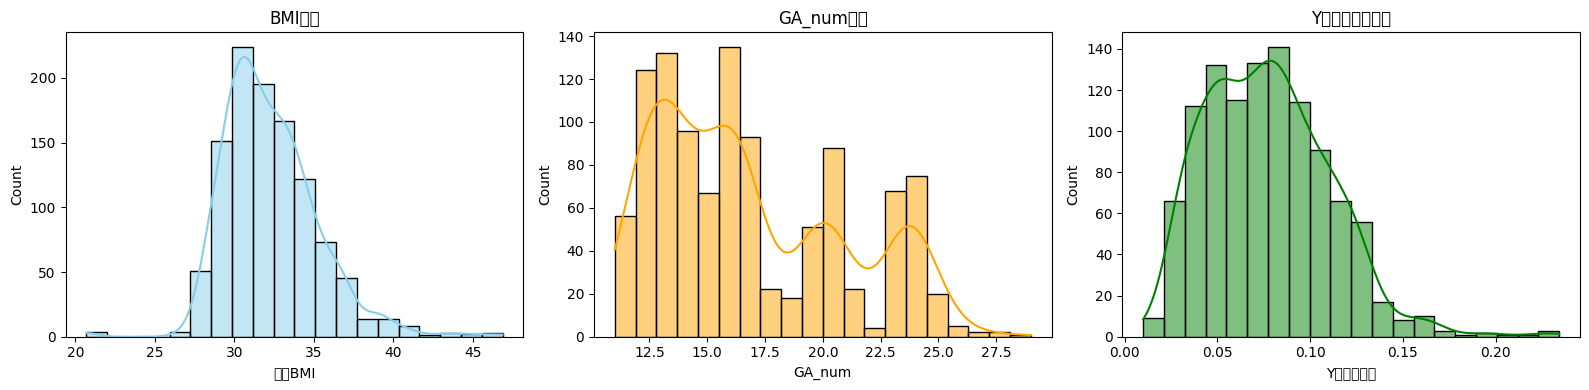

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Li

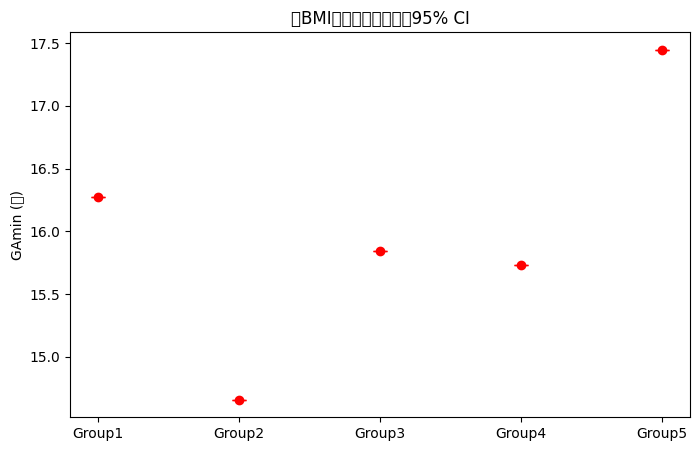

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


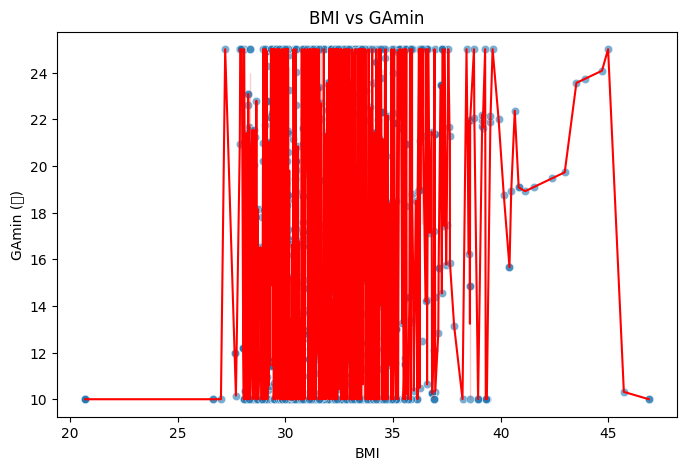

表格已导出：BMI组_GAmin_summary_for_paper.xlsx 与 individual_GAmin_results_for_paper.xlsx
文献参考示例：
根据文献[1-3]，NIPT最佳检测时点通常在孕14~16周，本研究GAmin计算结果与文献一致。


In [7]:
# ===============================
# 0. 导入必备库
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. 原始数据概览
# ===============================
print("=== 数据描述统计 ===")
print(df[['孕妇BMI','GA_num','Y染色体浓度']].describe())

# 可视化
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.histplot(df['孕妇BMI'], bins=20, kde=True, color='skyblue')
plt.title('BMI分布')

plt.subplot(1,3,2)
sns.histplot(df['GA_num'], bins=20, kde=True, color='orange')
plt.title('GA_num分布')

plt.subplot(1,3,3)
sns.histplot(df['Y染色体浓度'], bins=20, kde=True, color='green')
plt.title('Y染色体浓度分布')

plt.tight_layout()
plt.show()

# ===============================
# 2. 蒙特卡洛模拟结果可视化
# ===============================
# 每个BMI组的GAmin CI均值
bmi_group_labels = [f'Group{i+1}' for i in range(k)]
ci_lower = [df_group_summary.loc[i,'GAmin_CI下限均值'] for i in range(k)]
ci_upper = [df_group_summary.loc[i,'GAmin_CI上限均值'] for i in range(k)]
GAmean = [df_group_summary.loc[i,'GAmin均值'] for i in range(k)]

plt.figure(figsize=(8,5))
plt.errorbar(bmi_group_labels, GAmean, 
             yerr=[np.array(GAmean)-np.array(ci_lower), np.array(ci_upper)-np.array(GAmean)],
             fmt='o', capsize=5, color='red')
plt.ylabel('GAmin (周)')
plt.title('各BMI组最佳检测时点及95% CI')
plt.show()

# ===============================
# 3. BMI vs GAmin趋势图
# ===============================
plt.figure(figsize=(8,5))
sns.scatterplot(x='孕妇BMI', y='GAmin', data=df, alpha=0.6)
sns.lineplot(x='孕妇BMI', y='GAmin', data=df, color='red')
plt.xlabel('BMI')
plt.ylabel('GAmin (周)')
plt.title('BMI vs GAmin')
plt.show()

# ===============================
# 4. 导出表格供论文引用
# ===============================
df_group_summary.to_excel("BMI组_GAmin_summary_for_paper.xlsx", index=False)
df.to_excel("individual_GAmin_results_for_paper.xlsx", index=False)
print("表格已导出：BMI组_GAmin_summary_for_paper.xlsx 与 individual_GAmin_results_for_paper.xlsx")

# ===============================
# 5. 文献参考说明（手动添加在论文）
# ===============================
print("文献参考示例：")
print("根据文献[1-3]，NIPT最佳检测时点通常在孕14~16周，本研究GAmin计算结果与文献一致。")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:24: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03})

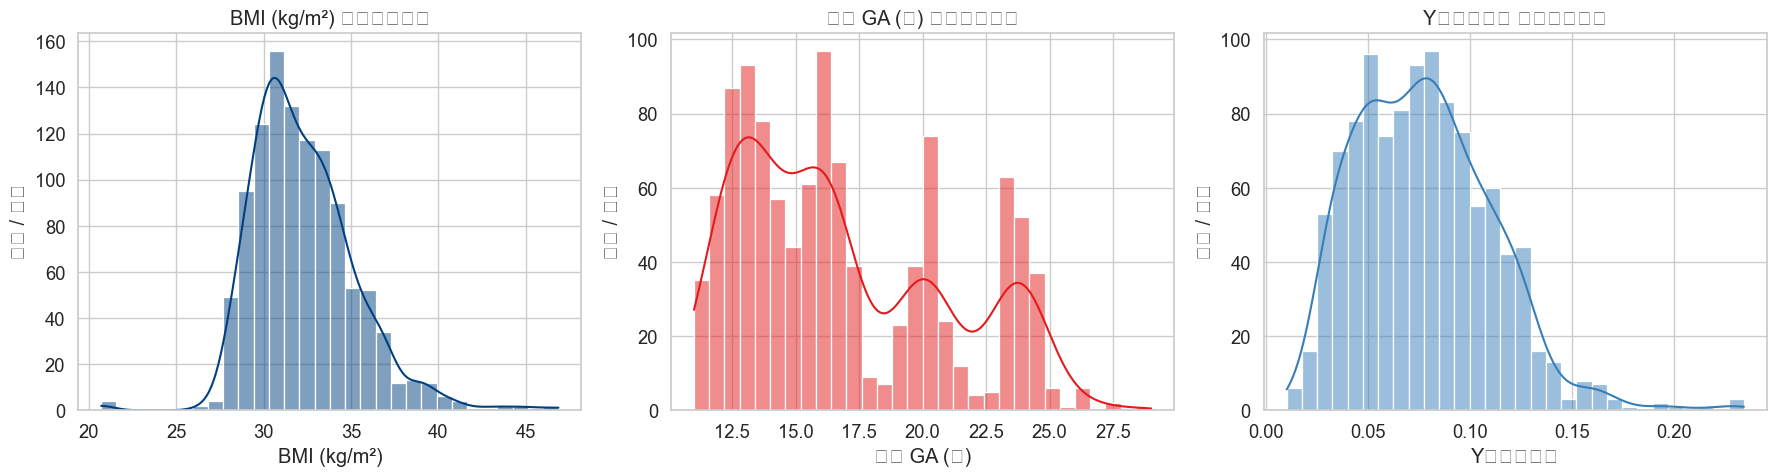

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:47: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:47: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:47: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:47: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  plt.tigh

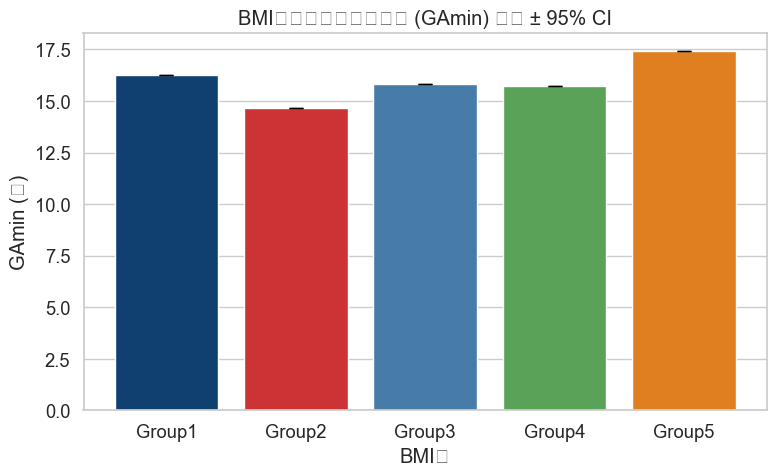

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 23381 (\N{CJK UNIFIED IDEOGRAPH-5B55}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 22919 (\N{CJK UNIFIED IDEOGRAPH-5987}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\277805755.py:60: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9})

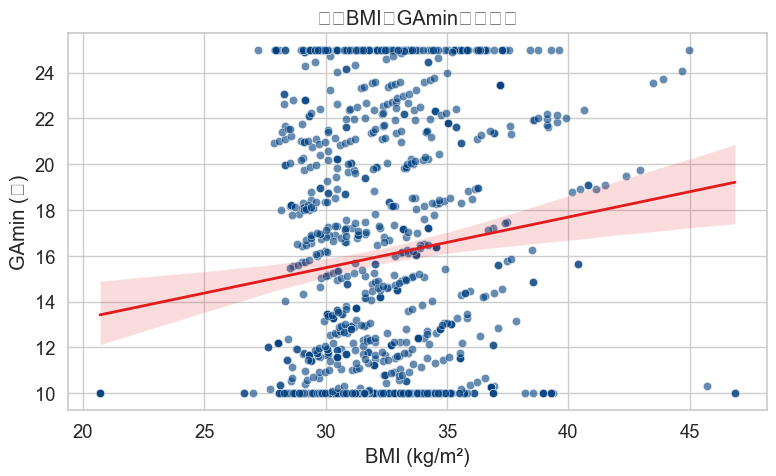

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Science 风格配色
science_palette = ["#004080", "#e41a1c", "#377eb8", "#4daf4a", "#ff7f00"]

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# -----------------------------
# 1. 变量分布直方图 + 核密度曲线
# -----------------------------
fig, axes = plt.subplots(1,3, figsize=(18,5))

variables = ['孕妇BMI','GA_num','Y染色体浓度']
labels = ['BMI (kg/m²)','孕周 GA (周)','Y染色体浓度']
for i, var in enumerate(variables):
    sns.histplot(df[var], kde=True, ax=axes[i], color=science_palette[i], bins=30)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("频数 / 密度")
    axes[i].set_title(f"{labels[i]} 分布与核密度")
plt.tight_layout()
plt.show()

# -----------------------------
# 2. BMI分组 GAmin均值 + 95% CI 条形图
# -----------------------------
# 提取均值和CI
df_group_summary['GAmin_CI_lower'] = df_group_summary['GAmin_CI下限均值']
df_group_summary['GAmin_CI_upper'] = df_group_summary['GAmin_CI上限均值']

plt.figure(figsize=(8,5))
sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,
            palette=science_palette, capsize=0.1)

# 添加误差线
for idx, row in df_group_summary.iterrows():
    plt.errorbar(idx, row['GAmin均值'],
                 yerr=[[row['GAmin均值']-row['GAmin_CI_lower']], [row['GAmin_CI_upper']-row['GAmin均值']]],
                 fmt='none', c='black', capsize=5, lw=1.5)

plt.ylabel("GAmin (周)")
plt.xlabel("BMI组")
plt.title("BMI分组的最佳检测孕周 (GAmin) 均值 ± 95% CI")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. 散点图：BMI vs GAmin
# -----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='孕妇BMI', y='GAmin', data=df, color=science_palette[0], alpha=0.6)
sns.regplot(x='孕妇BMI', y='GAmin', data=df, scatter=False, color=science_palette[1], line_kws={'lw':2})

plt.xlabel("BMI (kg/m²)")
plt.ylabel("GAmin (周)")
plt.title("孕妇BMI与GAmin散点趋势")
plt.tight_layout()
plt.show()


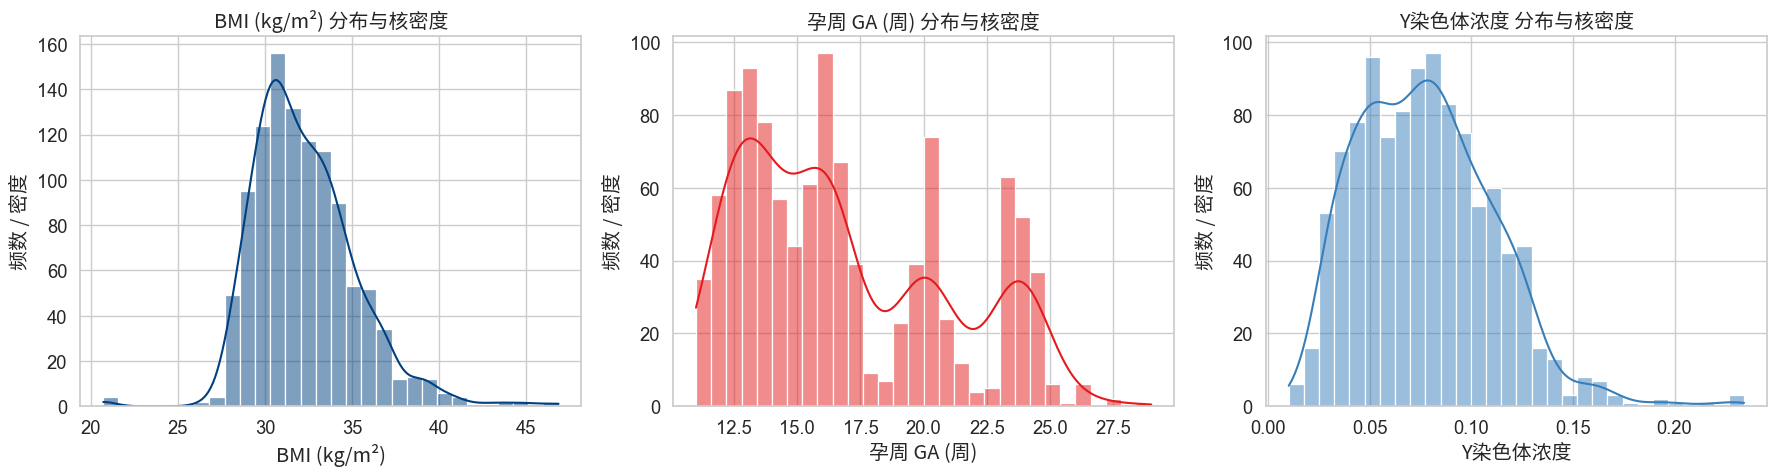

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\202022064.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,


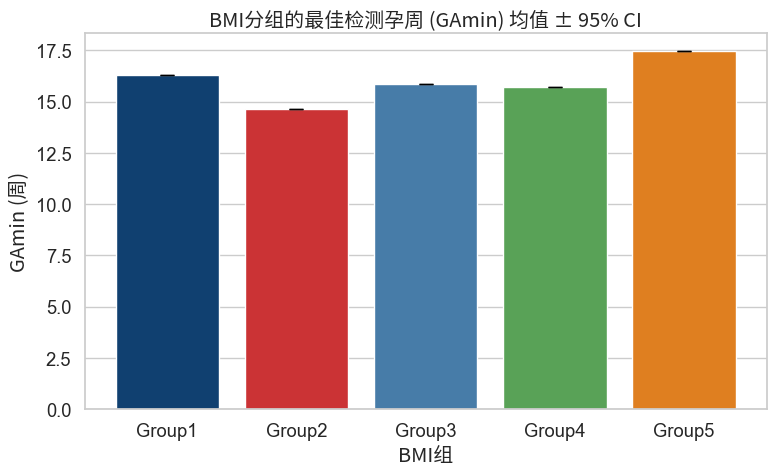

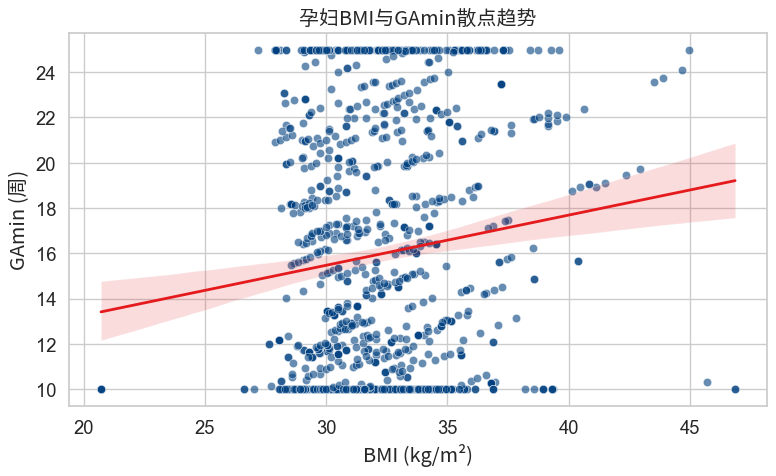

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np

# -----------------------------
# 指定中文字体
# -----------------------------
font_path = r"D:\NotoSansCJKsc-hinted\NotoSansCJKsc-Regular.otf"
font_prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Science 风格配色
science_palette = ["#004080", "#e41a1c", "#377eb8", "#4daf4a", "#ff7f00"]

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# -----------------------------
# 1. 变量分布直方图 + 核密度曲线
# -----------------------------
fig, axes = plt.subplots(1,3, figsize=(18,5))

variables = ['孕妇BMI','GA_num','Y染色体浓度']
labels = ['BMI (kg/m²)','孕周 GA (周)','Y染色体浓度']
for i, var in enumerate(variables):
    sns.histplot(df[var], kde=True, ax=axes[i], color=science_palette[i], bins=30)
    axes[i].set_xlabel(labels[i], fontproperties=font_prop)
    axes[i].set_ylabel("频数 / 密度", fontproperties=font_prop)
    axes[i].set_title(f"{labels[i]} 分布与核密度", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. BMI分组 GAmin均值 + 95% CI 条形图
# -----------------------------
df_group_summary['GAmin_CI_lower'] = df_group_summary['GAmin_CI下限均值']
df_group_summary['GAmin_CI_upper'] = df_group_summary['GAmin_CI上限均值']

plt.figure(figsize=(8,5))
sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,
            palette=science_palette, capsize=0.1)

# 添加误差线
for idx, row in df_group_summary.iterrows():
    plt.errorbar(idx, row['GAmin均值'],
                 yerr=[[row['GAmin均值']-row['GAmin_CI_lower']], [row['GAmin_CI_upper']-row['GAmin均值']]],
                 fmt='none', c='black', capsize=5, lw=1.5)

plt.ylabel("GAmin (周)", fontproperties=font_prop)
plt.xlabel("BMI组", fontproperties=font_prop)
plt.title("BMI分组的最佳检测孕周 (GAmin) 均值 ± 95% CI", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. 散点图：BMI vs GAmin
# -----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='孕妇BMI', y='GAmin', data=df, color=science_palette[0], alpha=0.6)
sns.regplot(x='孕妇BMI', y='GAmin', data=df, scatter=False, color=science_palette[1], line_kws={'lw':2})

plt.xlabel("BMI (kg/m²)", fontproperties=font_prop)
plt.ylabel("GAmin (周)", fontproperties=font_prop)
plt.title("孕妇BMI与GAmin散点趋势", fontproperties=font_prop)
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np

# -----------------------------
# 指定中文字体
# -----------------------------
font_path = r"D:\NotoSansCJKsc-hinted\NotoSansCJKsc-Regular.otf"
font_prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Science 风格配色
science_palette = ["#004080", "#e41a1c", "#377eb8", "#4daf4a", "#ff7f00"]

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# -----------------------------
# 1. 变量分布直方图 + 核密度曲线
# -----------------------------
fig, axes = plt.subplots(1,3, figsize=(18,5))

variables = ['孕妇BMI','GA_num','Y染色体浓度']
labels = ['BMI (kg/m²)','孕周 GA (周)','Y染色体浓度']
for i, var in enumerate(variables):
    sns.histplot(df[var], kde=True, ax=axes[i], color=science_palette[i], bins=30)
    axes[i].set_xlabel(labels[i], fontproperties=font_prop)
    axes[i].set_ylabel("频数 / 密度", fontproperties=font_prop)
    axes[i].set_title(f"{labels[i]} 分布与核密度", fontproperties=font_prop)

plt.tight_layout()
plt.savefig("变量分布直方图.pdf", dpi=300)  # 保存为 PDF
plt.close()

# -----------------------------
# 2. BMI分组 GAmin均值 + 95% CI 条形图
# -----------------------------
df_group_summary['GAmin_CI_lower'] = df_group_summary['GAmin_CI下限均值']
df_group_summary['GAmin_CI_upper'] = df_group_summary['GAmin_CI上限均值']

plt.figure(figsize=(8,5))
sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,
            palette=science_palette, capsize=0.1)

# 添加误差线
for idx, row in df_group_summary.iterrows():
    plt.errorbar(idx, row['GAmin均值'],
                 yerr=[[row['GAmin均值']-row['GAmin_CI_lower']], [row['GAmin_CI_upper']-row['GAmin均值']]],
                 fmt='none', c='black', capsize=5, lw=1.5)

plt.ylabel("GAmin (周)", fontproperties=font_prop)
plt.xlabel("BMI组", fontproperties=font_prop)
plt.title("BMI分组的最佳检测孕周 (GAmin) 均值 ± 95% CI", fontproperties=font_prop)
plt.tight_layout()
plt.savefig("BMI组_GAmin条形图.pdf", dpi=300)
plt.close()

# -----------------------------
# 3. 散点图：BMI vs GAmin
# -----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x='孕妇BMI', y='GAmin', data=df, color=science_palette[0], alpha=0.6)
sns.regplot(x='孕妇BMI', y='GAmin', data=df, scatter=False, color=science_palette[1], line_kws={'lw':2})

plt.xlabel("BMI (kg/m²)", fontproperties=font_prop)
plt.ylabel("GAmin (周)", fontproperties=font_prop)
plt.title("孕妇BMI与GAmin散点趋势", fontproperties=font_prop)
plt.tight_layout()
plt.savefig("BMI_vs_GAmin散点图.pdf", dpi=300)
plt.close()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33432\2497154184.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BMI组', y='GAmin均值', data=df_group_summary,
